# Monitoring Mangrove Extents  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background
[Global Mangrove Watch (GMW)](https://www.globalmangrovewatch.org/) is an initiative to track global mangrove extents. Using ALOS PALSAR and Landsat (optical) data to form a baseline extent of mangroves for the year 2010. More detailed information on the initiative can be found [here](http://data.unep-wcmc.org/datasets/45). The baseline extent of mangroves is provided as a shapefile, and shows the locations of mangroves across the entire world.

The shapefile used by this notebook is a country specific extraction from the global shapefile provided by GMW (from Bucomil, Guinea-Bissau). The purpose of this notebook is to use the extracted shapefile as a baseline for classifying mangroves through NDVI thresholding. We then analyze how the mangroves change over time in our area of interest.

## Description
The process begins with retrieving data for a specific area in a time series. This dataset is then compressed into a [geomedian]('../Frequently_used_code/Generating_geomedian_composites.ipynb') composite for each year. From the composite, we then calculate the NDVI values of each pixel in each year. The dataset is then masked, and the NDVI threshold is applied for mangrove classification. The following image shows the decision tree for the classification.

![Mangrove Decision Tree](../Supplementary_data/Mangroves_analysis/mangrove_decision_tree.png)


After classification, we can perform a variety of analyses on the data:
- We can estimate the change in mangrove areas by counting all the classified pixels for each year and plotting the trend line of the count. 
- We can also visualize the mangrove areas by plotting each classified pixel a certain color. 

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the [Load packages](#Load-packages) cell.

**After finishing the analysis**, return to the [Analysis parameters](#Analysis-parameters) cell, modify some values (e.g. choose a your own mangrove shapefile or time period to analyse) and re-run the analysis.

### Load packages

In [1]:
%matplotlib inline

import sys
import warnings
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils import geometry
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
warnings.filterwarnings("ignore")

sys.path.append("../Scripts")
from deafrica_bandindices import calculate_indices
from deafrica_coastaltools import tidal_tag
from deafrica_dask import create_local_dask_cluster
from deafrica_datahandling import load_ard
from deafrica_plotting import map_shapefile
from deafrica_spatialtools import xr_rasterize

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:42537 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


### Load the data

Connect to the datacube database and set up a processing cluster.

In [3]:
dc = datacube.Datacube(app="Mangrove")

### Analysis parameters

* `product_name`: The name of the satellite product to use.
* `time_range`: The date range to analyse (e.g. `("2017", "2020")`).
* `tide_range`: The minimum and maximum proportion of the tidal range to include in the analysis. For example, `tide_range = (0.25, 0.75)` will select all satellite images taken during mid-tide conditions (i.e. 25th to 75th percentile range). This allows us to remove any impact of tides on the classification of mangrove extent. Also, because Sentinel-2 is a sun-synchronoous sensor, the mid-tide is observed more than low and high tides, therefore it is advantageous to use the mid-tide extent as we will retain more satellite images.
* `vector_file`: The file path and name of a shapefile containing the mangrove extent.  A default example is provided. To run this analysis for another region try clipping the [GMW layer](https://data.unep-wcmc.org/datasets/45) to the extent you're interested in.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers the mangroves of Chwaka Bay, Zanzibar, Tanzania.

**To run the analysis on a different area** upload your mangrove extent shapefile using the _Upload Files_ button from the _File Browser_ tab to the left.

**To run the notebook for a different product or time**, use the [DEAfrica Explorer](https://explorer.digitalearth.africa), see what products cover your area of interest.



In [4]:
product_name = "s2_l2a"

time_range = ("2017", "2020")

tide_range = (0.25, 0.75) # only keep mid tides

vector_file = "../Supplementary_data/Mangroves_analysis/Guniea_Bissau_GMW_2010.shp"

### Preview the mangrove area

In [5]:
# read shapefile into a GeoDataFrame
gdf = gpd.read_file(vector_file)

map_shapefile(gdf, attribute=gdf.columns[0])

Label(value='')

Map(center=[11.844888888889102, -15.87688888888897], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Load cloud-masked Sentinel-2 data
The first step in this analysis is to load in Sentinel-2 data for the `geom` mangrove area shape and `time_range` we provided above. 
The code below uses the `load_ard` function to load in data from the Landsat 8 satellites for the area and time specified.
For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [6]:
# Covert all of the shapes into a datacube geometry
geom = geometry.Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)

# create a query dict for the datacube
query = {
    "time": time_range,
    "geopolygon": geom,
    "group_by": "solar_day",
    "resolution": (-20, 20),
}

# load data
ds = load_ard(
    dc=dc,
    products=[product_name],
    measurements=["red", "nir"],
    output_crs="EPSG:6933",
    dask_chunks={"time": 1, "x": 750, "y": 750},
    **query,
)
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 250 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 250, x: 876, y: 1347)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-05T11:27:37 ... 2020-10-16T11:...
  * y            (y) float64 1.514e+06 1.514e+06 ... 1.487e+06 1.487e+06
    spatial_ref  int32 6933
  * x            (x) float64 -1.541e+06 -1.541e+06 ... -1.523e+06 -1.523e+06
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Model tide heights

The location of the shoreline can vary greatly from low to high tide, which may impact the NDVI values of pixels where water and mangroves intermingle. In the code below, we aim to reduce the effect of tides by modelling tide height data, and keeping only the satellite images that were taken at specific tidal conditions. For example, if `tide_range = (0.00, 0.50)`, we are telling the analysis to focus only on satellite images taken when the tide between the lowest tidal conditions and the median (50th percentile) conditions.

The tidal_tag function below uses the [OTPS TPXO8 tidal model](https://www.tpxo.net/global) to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new tide_height attribute in our dataset.

> Important note: this function can only model tides correctly if the centre of your study area is located over water. If this isn't the case, you can specify a custom tide modelling location by passing a coordinate to tidepost_lat and tidepost_lon (e.g. tidepost_lat=14.283, tidepost_lon=-16.921).


In [7]:
# Calculate tides for each timestep in the satellite dataset
ds = tidal_tag(ds=ds, tidepost_lat=11.7443, tidepost_lon=-15.9949)

# Print the output dataset with new `tide_height` variable
print(ds)

Using user-supplied tide modelling location: -15.99, 11.74
<xarray.Dataset>
Dimensions:      (time: 250, x: 876, y: 1347)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-05T11:27:37 ... 2020-10-16T11:...
  * y            (y) float64 1.514e+06 1.514e+06 ... 1.487e+06 1.487e+06
    spatial_ref  int32 6933
  * x            (x) float64 -1.541e+06 -1.541e+06 ... -1.523e+06 -1.523e+06
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    tide_height  (time) float64 -0.669 0.398 0.301 -0.735 ... 0.239 -0.399 1.057
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


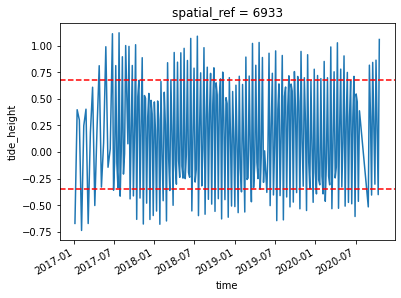

In [8]:
# Calculate the min and max tide heights to include based on the % range
min_tide, max_tide = ds.tide_height.quantile(tide_range)

# Plot the resulting tide heights for each Landsat image:
ds.tide_height.plot()
plt.axhline(min_tide, c="red", linestyle="--")
plt.axhline(max_tide, c="red", linestyle="--")
plt.show()

### Filter satellite images by tide height

Here we take the dataset and only keep the images with tide heights we want to analyse (i.e. tides within the heights given by `tide_range`). This will result in a smaller number of images.


In [9]:
# Keep timesteps larger than the min tide, and smaller than the max tide
ds_filtered = ds.sel(time=(ds.tide_height > min_tide) & (ds.tide_height <= max_tide))
print(ds_filtered)

<xarray.Dataset>
Dimensions:      (time: 124, x: 876, y: 1347)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-15T11:34:00 ... 2020-10-06T11:...
  * y            (y) float64 1.514e+06 1.514e+06 ... 1.487e+06 1.487e+06
    spatial_ref  int32 6933
  * x            (x) float64 -1.541e+06 -1.541e+06 ... -1.523e+06 -1.523e+06
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    tide_height  (time) float64 0.398 0.301 0.248 0.403 ... 0.274 -0.301 0.239
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Combine observations into noise-free summary images

In the code below, we take the time series of images and combine them into single images for each year using the `median NDVI`. The *Normalised Difference Vegetation Index* (NDVI) shows vegetation and is used for mangrove classification within the mangrove mask.

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

For more information on indices, see the [Calculating Band Indices](../Frequently_used_code/Calculating_band_indices.ipynb) notebook.


> Note: This step can take several minutes to load if the study area is large. We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the Dask dashboard in DE Africa section of the Dask notebook.

In [10]:
#calculate NDVI
ds_filtered = calculate_indices(ds_filtered, index='NDVI', collection = 's2')

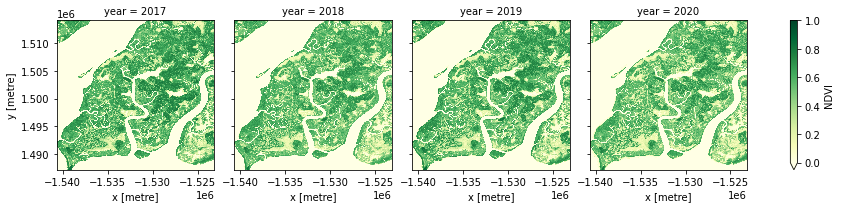

In [11]:
# generate median annual summaries of NDVI
ds_summaries = ds_filtered.NDVI.groupby("time.year").median().compute()

# Plot the output summary images
ds_summaries.plot(col="year", cmap="YlGn", col_wrap=len(ds_summaries.year.values), vmin=0, vmax=1.0);

## Mangrove classification
### Apply a mask of the mangrove area

We will use the mangrove polygon from the Global Mangrove Watch dataset to create a mask, so we can work with only the pixels in the mangrove area.  To convert the vector polygon to a raster mask, we use `xr_rasterize`. For more information on indices, see the [Rasterizing vectors & vectorizing rasters](../Frequently_used_code/Rasterize_vectorize.ipynb) notebook.

In [12]:
# Convert the mangrove polygon to a raster that matches our imagery data.
mask = xr_rasterize(gdf, ds_summaries)

# Mask dataset to set pixels outside the polygon to `NaN`
ds_summaries_masked = ds_summaries.where(mask)

Rasterizing to match xarray.DataArray dimensions (1347, 876)


### Calculating regular and closed mangroves

Using the [mangrove decision tree](#Description) above, we can classify the pixels as:

* **mangroves:** pixels in the mangrove area with an `NDVI > 0.4`
    * **regular mangroves:** mangroves with `NDVI <= 0.7`
    * **closed mangroves:** mangroves with `NDVI > 0.7`

In [13]:
all_mangroves = xr.where(ds_summaries_masked > 0.4, 1, np.nan)

regular_mangroves = all_mangroves.where(ds_summaries_masked <= 0.7)
closed_mangroves = all_mangroves.where(ds_summaries_masked > 0.7)

### Plot the mangrove types

Again we will combine the mangrove types for easier plotting.

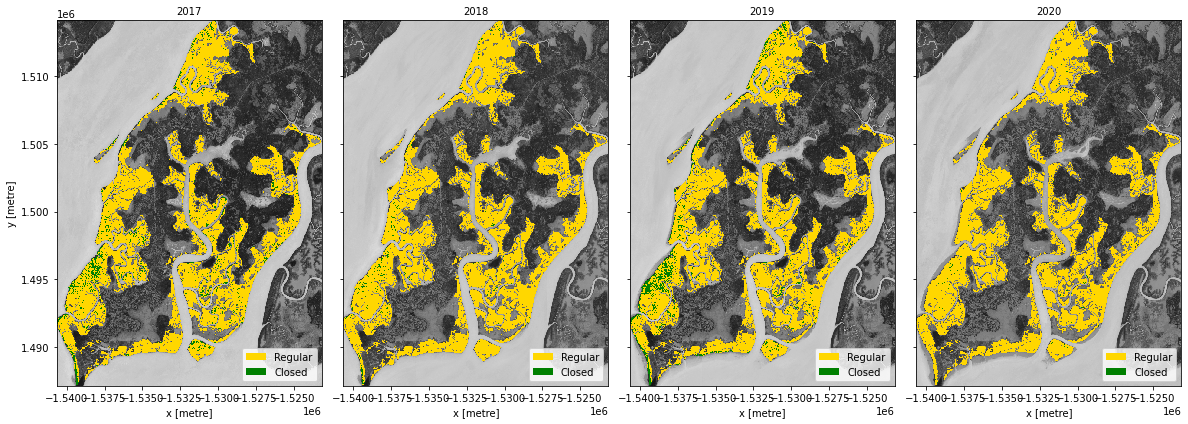

In [14]:
mangroves = xr.concat(
    [regular_mangroves, closed_mangroves, all_mangroves],
    dim=pd.Index(["regular", "closed", "total"], name="mangrove_type"),
)

regular_color = "gold"
closed_color = "green"

# Create a FacetGrid, so there is a subplot for each year
grid = xr.plot.FacetGrid(
    mangroves,
    col="year",
    col_wrap=len(ds_summaries.year.values),
    size=6,
    aspect=mangroves.x.size / mangroves.y.size,
)

# Define the sub-plot of mangrove types with a legend on a background of grey-scale NDVI
def plot_mangrove(data, ax, **kwargs):
    ds_summaries.sel(year=data.year).plot.imshow(
        ax=ax, cmap="Greys", vmin=-1, vmax=1, add_colorbar=False, add_labels=False
    )
    data.sel(mangrove_type="regular").plot.imshow(
        ax=ax,
        cmap=ListedColormap([regular_color]),
        add_colorbar=False,
        add_labels=False,
    )
    data.sel(mangrove_type="closed").plot.imshow(
        ax=ax, cmap=ListedColormap([closed_color]), add_colorbar=False, add_labels=False
    )

    ax.legend(
        [Patch(facecolor=regular_color), Patch(facecolor=closed_color)],
        ["Regular", "Closed"],
        loc="lower right",
    )

# Plot the each year sub-plot
grid.map_dataarray(plot_mangrove, x="x", y="y", add_colorbar=False)

# Update sub-plot titles
for i, name in np.ndenumerate(grid.name_dicts):
    grid.axes[i].title.set_text(str(name["year"]));

## Mangrove change
### Plot the change of mangrove classification in area over time

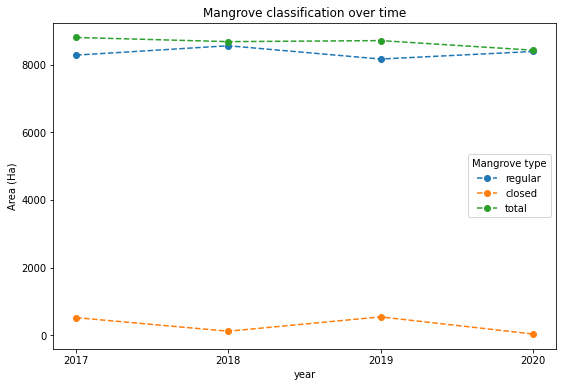

In [15]:
# Convert pixel count to km^2
m2_per_ha = 10000
m2_per_pixel = query["resolution"][1] ** 2
mangrove_area = mangroves.sum(dim=("x", "y")) * m2_per_pixel / m2_per_ha

# Fix axis and legend text
mangrove_area.name = r"Area (Ha)"
mangrove_area = mangrove_area.rename(mangrove_type="Mangrove type")

# Plot the line graph
mangrove_area.plot(
    hue="Mangrove type",
    x="year",
    xticks=mangrove_area.year,
    size=6,
    linestyle="--",
    marker="o",
)
plt.title("Mangrove classification over time");

### Monitoring change in mangroves

We can calculate the growth and loss of mangroves between the first and last year in our timeseries

In [16]:
total_mangroves = (mangroves.loc["total"] == 1).astype(int)

# Calculate the change in mangrove extent
old = total_mangroves.isel(year=0)
new = total_mangroves.isel(year=-1)
change = new - old

# reclassify into growth, loss and stable
growth = xr.where(change == 1, 1, np.nan)
loss = xr.where(change == -1, -1, np.nan)
stable = old.where(~change)
stable = xr.where(stable == 1, 1, np.nan)

#### Plot the change

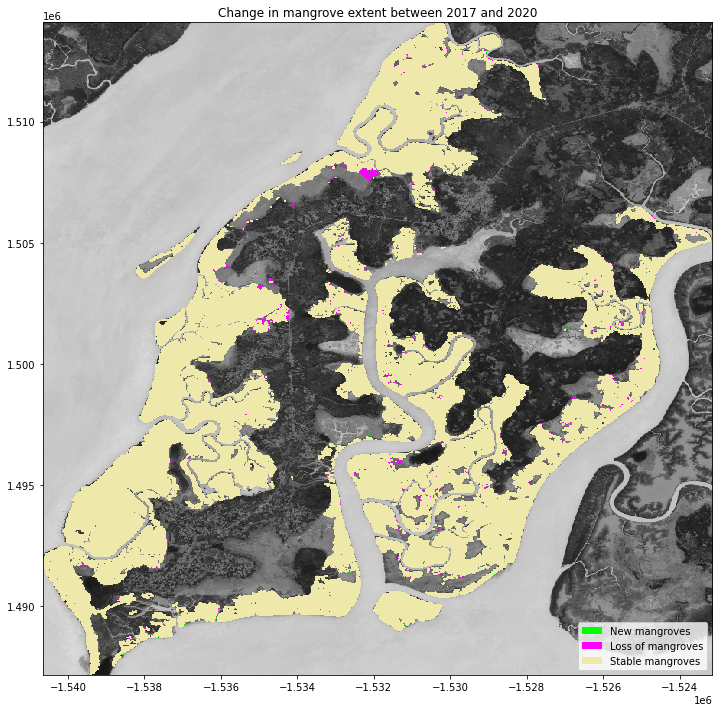

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ds_summaries.isel(year=0).plot.imshow(
    ax=ax, cmap="Greys", vmin=-1, vmax=1, add_colorbar=False, add_labels=False
)
stable.plot(
    ax=ax, cmap=ListedColormap(["palegoldenrod"]), add_colorbar=False, add_labels=False
)
growth.plot.imshow(
    ax=ax, cmap=ListedColormap(["lime"]), add_colorbar=False, add_labels=False
)
loss.plot.imshow(
    ax=ax, cmap=ListedColormap(["fuchsia"]), add_colorbar=False, add_labels=False
)
ax.legend(
    [
        Patch(facecolor='lime'),
        Patch(facecolor='fuchsia'),
        Patch(facecolor="palegoldenrod"),
    ],
    ["New mangroves", "Loss of mangroves", "Stable mangroves"],
    loc="lower right",
)
plt.title('Change in mangrove extent between {} and {}'.format(ds_summaries.year.values[0], ds_summaries.year.values[-1]));

### Determine the net change between years

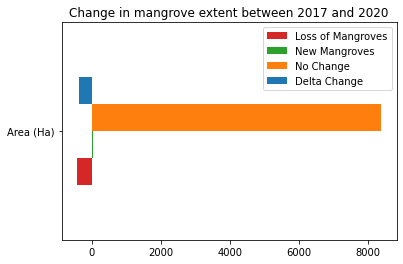

In [18]:
loss_count = loss.sum().values * m2_per_pixel / m2_per_ha
gain_count = growth.sum().values * m2_per_pixel / m2_per_ha
stable_count = stable.sum().values* m2_per_pixel / m2_per_ha

counts = {
          'Loss of Mangroves': int(loss_count.item(0)),
          'New Mangroves': int(gain_count.item(0)),
          'No Change': int(stable_count.item(0)),
          'Delta Change': int(gain_count.item(0) + loss_count.item(0))
          }

df = pd.DataFrame(counts, index=['Area (Ha)'])
df.plot.barh(color=['tab:red','tab:green','tab:orange','tab:blue'])
plt.title('Change in mangrove extent between {} and {}'.format(ds_summaries.year.values[0], ds_summaries.year.values[-1]));


## Advanced: Compare Recent Mangrove Extent to GMV 2010

In the previous plots, we were calculating the change in mangrove extent from the start of the Sentinel-2 time series (2017) until now (2020). However, our baseline mangrove extent map, the Global Mangrove Watch (GMW) layer, was developed in 2010. Thus, the mangrove extent may have change significantly between 2010 and the beginning of the Sentinel-2 archive.  We can use the GMW layer to inspect how mangrove extent has changed since the development of the 2010 product. A word of caution here, the GMW product was developed using a different methodology to the one used here, so differences in mangrove extent may be attributable to the different methods. Nevertheless, this should still provide us with a reasonable indication of the changes that have occurred between 2010 and the beginning of the Sentinel-2 archive in 2017.

### Determine change between 2010 and now

In [19]:
#Find the change between now and the baseline
baseline_change = old - mask

# reclassify into growth, loss and stable
growth_bs = xr.where(baseline_change == 1, 1, np.nan)
loss_bs = xr.where(baseline_change == -1, -1, np.nan)
stable_bs = mask.where(~baseline_change)
stable_bs = xr.where(stable == 1, 1, np.nan)

#### Plot the change

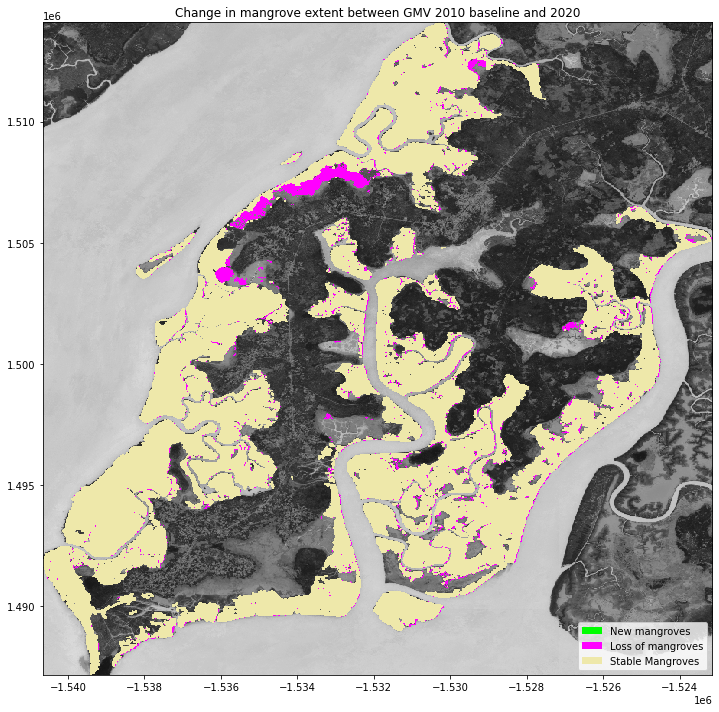

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ds_summaries.isel(year=0).plot.imshow(
    ax=ax, cmap="Greys", vmin=-1, vmax=1, add_colorbar=False, add_labels=False
)
stable_bs.plot(
    ax=ax, cmap=ListedColormap(["palegoldenrod"]), add_colorbar=False, add_labels=False
)
growth_bs.plot.imshow(
    ax=ax, cmap=ListedColormap(["lime"]), add_colorbar=False, add_labels=False
)
loss_bs.plot.imshow(
    ax=ax, cmap=ListedColormap(["fuchsia"]), add_colorbar=False, add_labels=False
)
ax.legend(
    [
        Patch(facecolor='lime'),
        Patch(facecolor='fuchsia'),
        Patch(facecolor="palegoldenrod"),
    ],
    ["New mangroves", "Loss of mangroves", "Stable Mangroves"],
    loc="lower right",
)
plt.title('Change in mangrove extent between GMV 2010 baseline and {}'.format(ds_summaries.year.values[-1]));

### Determine the net change between 2010 and recent

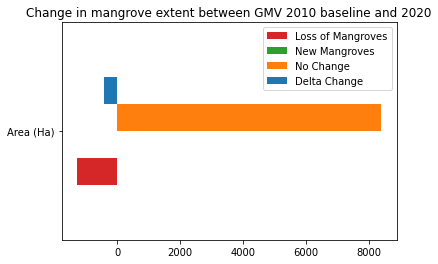

In [21]:
loss_bs_count = loss_bs.sum().values * m2_per_pixel / m2_per_ha
gain_bs_count = growth_bs.sum().values * m2_per_pixel / m2_per_ha
stable_bs_count = stable_bs.sum().values* m2_per_pixel / m2_per_ha

counts = {
          'Loss of Mangroves': int(loss_bs_count.item(0)),
          'New Mangroves': int(gain_bs_count.item(0)),
          'No Change': int(stable_bs_count.item(0)),
          'Delta Change': int(gain_bs_count.item(0) + loss_count.item(0))
          }

df = pd.DataFrame(counts, index=['Area (Ha)'])
df.plot.barh(color=['tab:red','tab:green','tab:orange','tab:blue'])
plt.title('Change in mangrove extent between GMV 2010 baseline and {}'.format(ds_summaries.year.values[-1]));

## Drawing conclusions
Here are some questions to think about:

* What are the causes of mangrove growth and loss? 

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** June 2020

**Compatible `datacube` version:** 

In [22]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()